### Initial look at clustering for Asteroid tracklets:

Asteroid tracklets CS 182 project: Paul Blankley, Ryan Janssen, Matthew Holman

Potentially useful docs / sources:

Blog: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/#Inconsistency-Method

Cophenet: https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.cophenet.html

Linkage: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

Inconsistent: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.inconsistent.html

Fcluster: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html



In [7]:
# Imports
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import numpy as np
from collections import defaultdict

%matplotlib inline

In [8]:
with open('../ITF/test_r2.5_rd0.out','r') as file:
    lines = file.read().split('\n')
    r2p5 = [i.split() for i in lines[:-1]]
    mxs = [float(i[1]) for i in r2p5]
    cxs = [float(i[2]) for i in r2p5]
    mys = [float(i[3]) for i in r2p5]
    cys = [float(i[4]) for i in r2p5]
    

In [9]:
# Basic Asteroid vector plot
# fig=plt.figure(figsize=(18, 16))
# plt.quiver(cxs, cys, mxs, mys, scale=0.2, width=0.0005)
# plt.xlim(-0.0, 0.3)
# plt.ylim(-0.2, 0.1)
# plt.xlabel('alpha')
# plt.ylabel('beta')
# plt.title('Asteroids')

The below dendrogram shows the higher level clustering of the hierarchical model.  For a good tutorial and more reading on this type of clustering check this out: https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

NOTE: This is the high level clustering, we are interested in the low level where the tracklets are very close to each other.

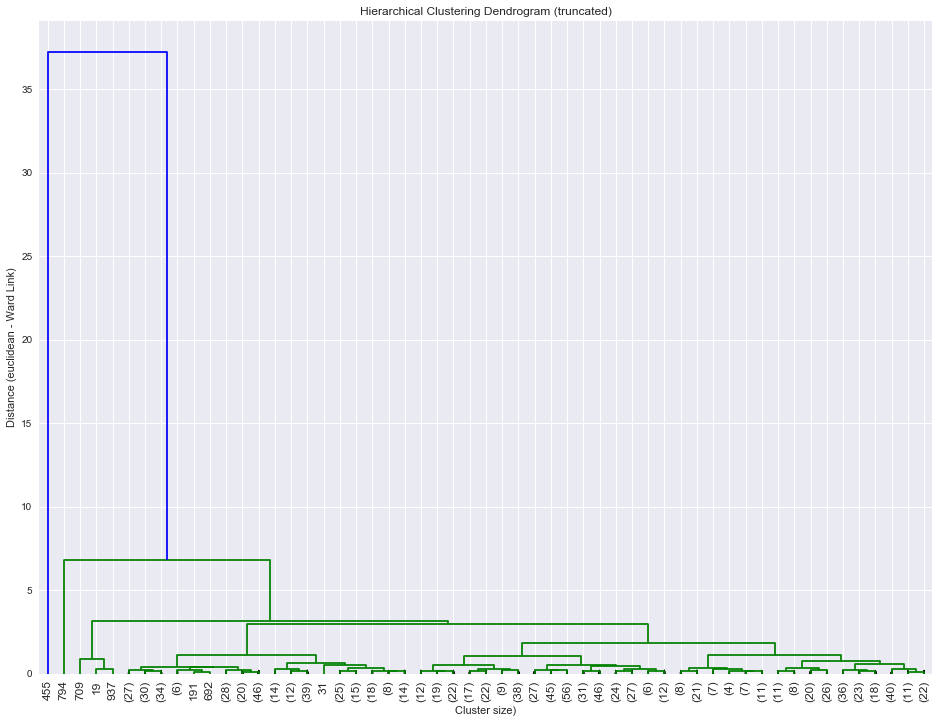

In [18]:
# Convert the array to a numpy array
numeric_vals = np.array([mxs, cxs, mys, cys]).T

# Make linkage
Z = linkage(numeric_vals, 'ward')

# Dendogram
fig,ax = plt.subplots(figsize=(16,12))
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Cluster size)')
plt.ylabel('Distance (euclidean - Ward Link)')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=55,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

The correlation coefficient below compares the accuracy of the dendrogram distance (the link height) with the actual pairwise distances in the original matrix to see how well the dendrogram preserves pairwise distance.  The closer the number is to 1.0 the better. Check out this link for further reading: https://en.wikipedia.org/wiki/Cophenetic_correlation

The Cophenetic distance is the measure the `i_cutp` variable represents in the fcluster clustering method under many paradigms, but *not* inconsistent.  If a cluster node and all its descendants have an inconsistent value less than or equal to $t$ (our `i_cutp`) then all its leaf descendants belong to the same cluster. When no non-singleton cluster meets this criterion, every node is assigned to its own cluster.

Cophenetic correlation coefficient: 0.854568379056
Avg Cophenetic distance: 2.02351879883


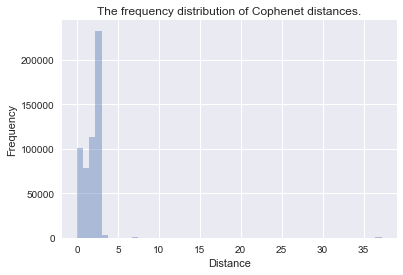

In [19]:
# Cluster with a max d
max_d = 0.00005
clusters_md = fcluster(Z, max_d, criterion='distance')

# Cluster using inconsistency metric
# Objects between clusters have no greater distance than the dist_bet value below 
i_cutp = .9
incon = inconsistent(Z,20)
clusters_i = fcluster(Z, i_cutp, criterion='inconsistent', depth=10)

c_cor, coph_dists = cophenet(Z,pdist(numeric_vals))
print('Cophenetic correlation coefficient:',c_cor)
print('Avg Cophenetic distance:',coph_dists.mean())
sns.distplot(coph_dists,kde=False)
plt.title('The frequency distribution of Cophenet distances.')
plt.xlabel('Distance')
plt.ylabel('Frequency')

Here are the goods (kind of).  This plot shows the clustering by color and I think we can see some pretty good behavior initially from the clusters.  They look pretty tight and seem to be seperating the data in a meaningful way.  This can be significantly improved by dropping some less useful clusters and by tuning the hyperparameters to optimally cluster the vectors.  I will discuss the hyperparameters in detail later. 

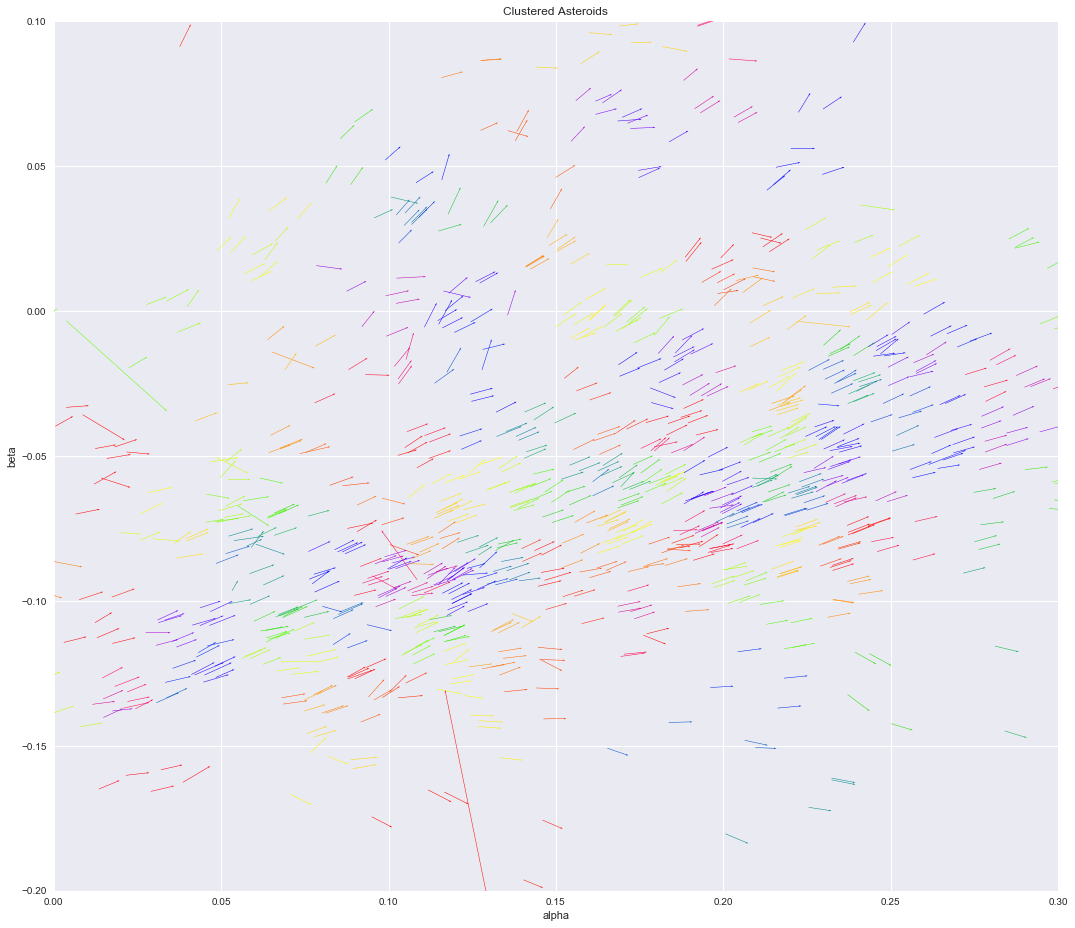

In [20]:
fig=plt.figure(figsize=(18, 16))
plt.quiver(cxs, cys, mxs, mys, clusters_i, cmap='prism',scale=0.2, width=0.0005)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Clustered Asteroids')

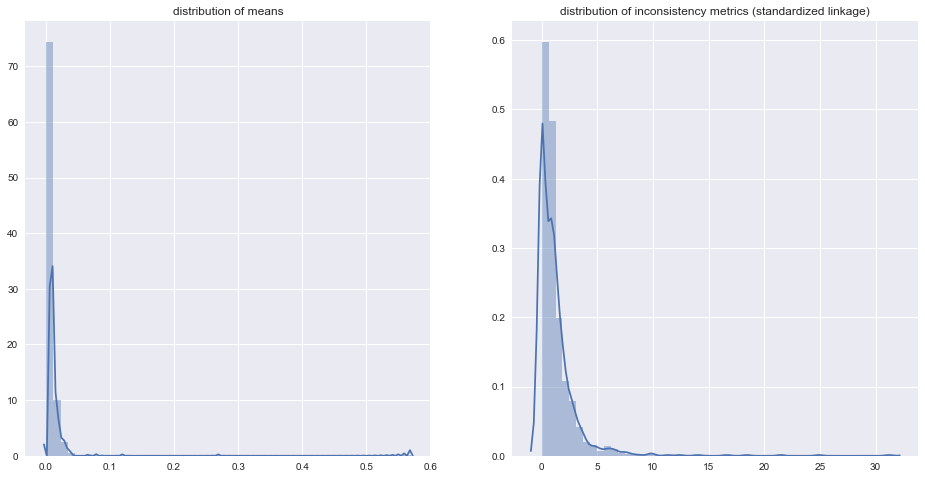

In [21]:
# Plots of distributions of the inconsistency clusters
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
sns.distplot(incon[:,0],ax=ax1)
ax1.set_title('distribution of means')

# sns.distplot(np.log(incon[:,0]),ax=ax2)
# ax2.set_title('log distribution of means')

sns.distplot(incon[:,3],ax=ax2)
ax2.set_title('distribution of inconsistency metrics (standardized linkage)')

# sns.distplot(incon[:,2],ax=ax4)
# ax4.set_title('distribution of the number of links in the calculation')

Inconsistency is the first unsupervised method we decided to apply to this problem.  Inconsistency has two hyperparameters.  The first is the `depth` value.  This value tells the algorithm what depth to stop searching as it goes up the tree.  The next is the `threshold` (our `i_cut` variable) value which we use to specify the inconsistency value above which we will not cluster any points, and below which we say the elements we clustered belong in a cluster together.

NOTES:

Objects between clusters have no greater distance than the `dist_bet` value below.

Value, that is `clusters_i[j]`, in `clusters_i` is the key of the cluster the point j belongs to, whereas the output from inconsistent at `incon[j]` relates to the jth *cluster* not the jth point in the original data. Thus, the index of `incon` is directly related to the value of `clusters_i`.

646


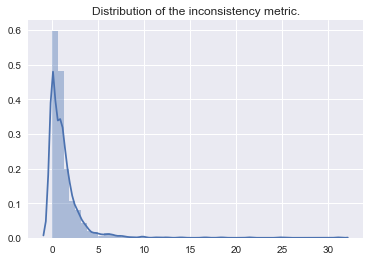

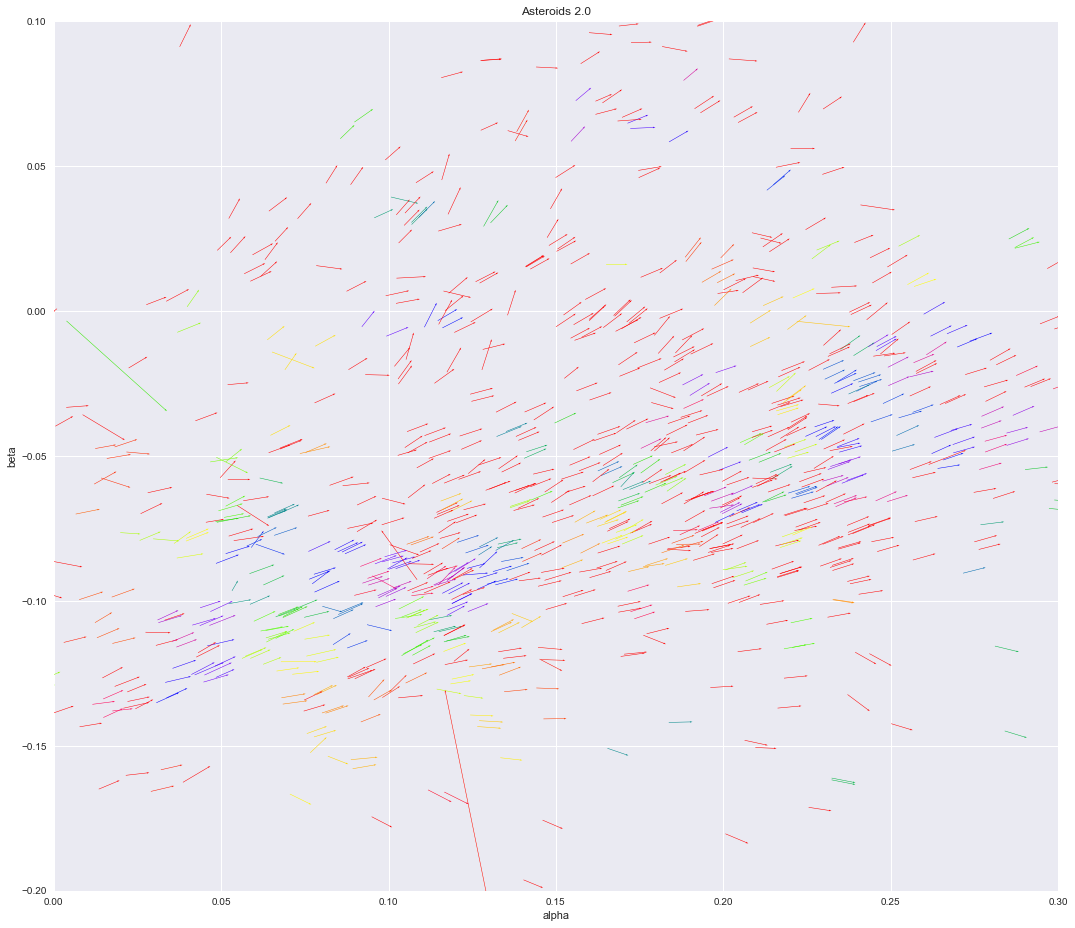

In [49]:
# Arb set cutpoint based on the inconsistency metric 
cutoff = .5

########################################################

# Cluster with a max d
#max_d = 0.05
#clusters_md = fcluster(Z, max_d, criterion='distance')

# Cluster using inconsistency metric 
dist_bet = .0000008  # seems to control the proximity of vectors we allow to cluster
incon = inconsistent(Z,20)
clusters_i = fcluster(Z, dist_bet, criterion='inconsistent', depth=2)
print(max(clusters_i))

# Drop clusters that don't meet a certain cutoff for the inconsistency metric (col 4 of the incon output)
sns.distplot(incon[:,3])
plt.title('Distribution of the inconsistency metric.')
plt.show()

for i in range(len(incon)):
    t = incon[i,3]>cutoff
    if t:
        if i in clusters_i:
            for j,itm in enumerate(clusters_i):
                if itm==i:
                    clusters_i[j] = 1

# Asteroid plot
fig=plt.figure(figsize=(18, 16))
plt.quiver(cxs, cys, mxs, mys, clusters_i, cmap='prism',scale=0.2, width=0.0005)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Asteroids 2.0')

Now we can assign the labels to the clusters.  We know the output of the `fcluster` method is going to be in order of the original data so this is a valid assignment. 

Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html

In [61]:
# Create the labels vector
labels = [i[0] for i in r2p5]

# Create a dict with the cluster id as the key and the associated tracklet id's as the values
clusters_with_tags = defaultdict(list)
for i, itm in enumerate(clusters_md):
    clusters_with_tags[itm].append(labels[i])


num_obs_in_clusters = [len(val) for k, val in clusters_with_tags.items() if k !=1]

print('We found {} different clusters of tracklets.'.format(len(clusters_with_tags.keys())-1))
print('The average cluster size is {0:.3f}'.format(np.mean(num_obs_in_clusters)))
print('We clustered {} tracklet ids.'.format(np.sum(num_obs_in_clusters)))
print('Largest cluster:',max(num_obs_in_clusters))

We found 431 different clusters of tracklets.
The average cluster size is 2.385
We clustered 1028 tracklet ids.
Largest cluster: 67


In [62]:
clusters_with_tags[1]=[None]
clusters_with_tags

defaultdict(list,
            {1: [None],
             2: ['P10CWVj'],
             3: ['YQA70E2', 'A103Hgs'],
             4: ['YQA70E3', 'YQA75D1'],
             5: ['YQA70E4'],
             6: ['YQA70D5'],
             7: ['X51521'],
             8: ['YQA714D'],
             9: ['P10CWVE'],
             10: ['P10DHos', 'P10CWzA'],
             11: ['P10CvKG', 'P10CqPu'],
             12: ['P10CqRp'],
             13: ['P10CvKa'],
             14: ['P10CvKw'],
             15: ['P10CvKp'],
             16: ['P10DHoe'],
             17: ['P10DftC'],
             18: ['P10Dfs4'],
             19: ['P10CWCm'],
             20: ['P10DfuO'],
             21: ['P10CWBB'],
             22: ['RvQ51F'],
             23: ['P10CWBz'],
             24: ['P10DfwF'],
             25: ['YSAE24A'],
             26: ['A103AWw'],
             27: ['P10CvKm'],
             28: ['A103J3Z'],
             29: ['YSAE24B'],
             30: ['P10DHpi'],
             31: ['P10DHpv'],
             32: ['YQA76

[[  6.30874815e-05   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.20074368e-04   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.73729758e-04   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  1.76152826e-04   0.00000000e+00   1.00000000e+00   0.00000000e+00]
 [  2.12454289e-04   0.00000000e+00   1.00000000e+00   0.00000000e+00]]
[386  45   2 291 307  91 276  18 277 301 366 266 196 285 196 241 292 273
 155 428 268 111 330 288 213]


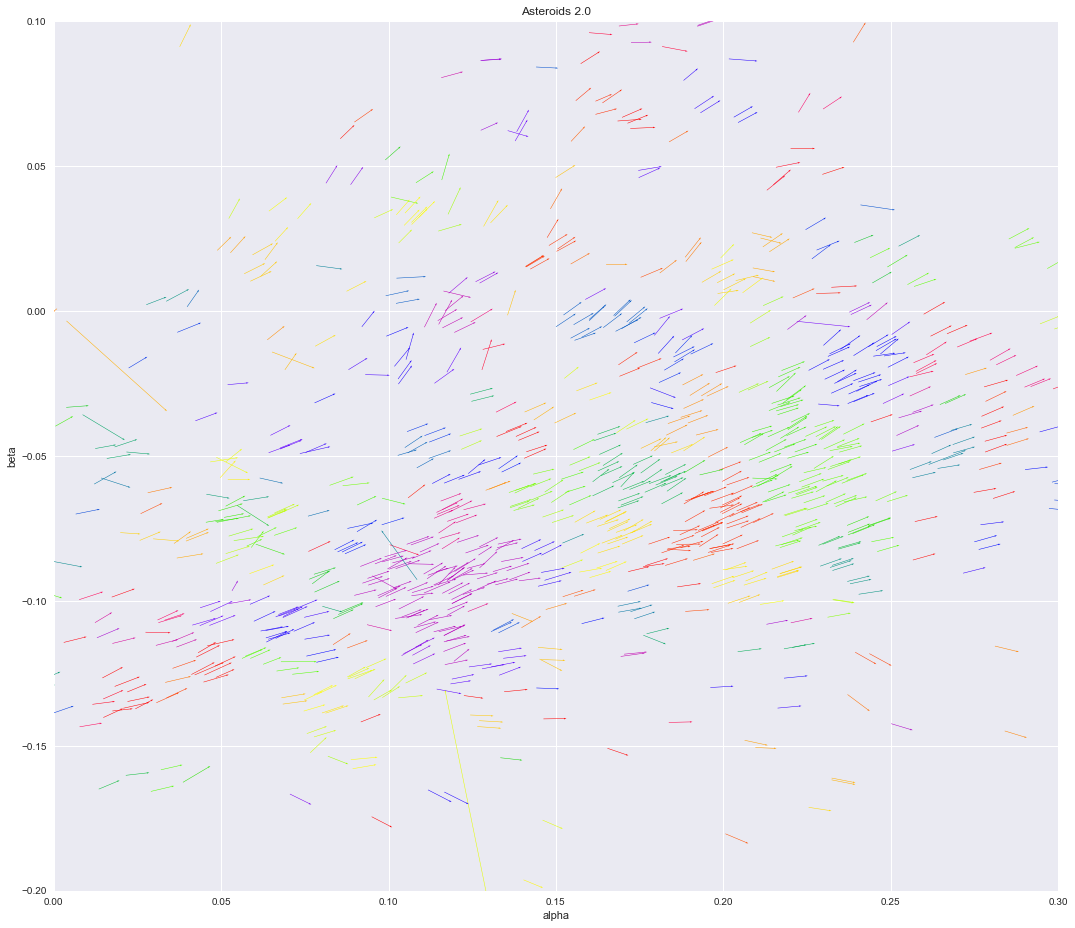

In [59]:
# Arb set cutpoint based on the inconsistency metric 
cutoff = .5

########################################################

Z = linkage(numeric_vals, 'single')

# Cluster with a max d
max_d = 0.005
clusters_md = fcluster(Z, max_d, criterion='distance')
incon = inconsistent(Z,20)

print(incon[:5])
print(clusters_md[:25])
# Asteroid plot
fig=plt.figure(figsize=(18, 16))
plt.quiver(cxs, cys, mxs, mys, clusters_md, cmap='prism',scale=0.2, width=0.0005)
plt.xlim(-0.0, 0.3)
plt.ylim(-0.2, 0.1)
plt.xlabel('alpha')
plt.ylabel('beta')
plt.title('Asteroids 2.0')